In [1]:
import torch 
import torch.nn as nn
import numpy as np
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, random_split
import tifffile as tiff
from PIL import Image
import os
from torchvision import transforms
from sklearn.preprocessing import StandardScaler

WIDTH = 56 
HEIGHT = 56

# Define transform for images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load images from directory
directory = 'Gauss_1.0_0.3\\Gauss_1.0_0.3'
all_imgs = []
for filename in os.listdir(directory):
    if filename.endswith(".tiff"):
        img_path = os.path.join(directory, filename)
        img_array = tiff.imread(img_path)
        img = Image.fromarray(img_array)
        img_tensor = transform(img)
        all_imgs.append(img_tensor)
print(f'Loaded {len(all_imgs)} images.')

# Split images into categories
p = 1000
Emcal = all_imgs[:p]
Hcal = all_imgs[p:2*p]
Tracker = all_imgs[2*p:3*p]
Truth = all_imgs[3*p:4*p]

# Combine the three images into one tensor (similar to 3 channels)
X = [torch.stack((emcal, hcal, tracker)) for emcal, hcal, tracker in zip(Emcal, Hcal, Tracker)]
X = torch.stack(X).squeeze(2)  # Remove the extra dimension if needed
Y = torch.stack(Truth)

# Print shapes for verification
print(f'X shape: {X.shape}')  # Should be (p, 3, 56, 56)
print(f'Y shape: {Y.shape}')  # Should be (p, 1, 56, 56)

# Flatten the spatial dimensions of X and Y for the fully connected network
X = X.view(X.size(0), -1)  # Flatten to (p, 3*56*56)
Y = Y.view(Y.size(0), -1)  # Flatten to (p, 1*56*56)


Loaded 4000 images.
X shape: torch.Size([1000, 3, 56, 56])
Y shape: torch.Size([1000, 1, 56, 56])


In [2]:
#All plus one is taken as logarithmic
# X = torch.log(X + 1)
# Y = torch.log(Y + 1)

In [3]:
# Split data into training, validation, and test sets
import time
seed = int(time.time())
torch.manual_seed(seed)
dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [5]:
# Data loaders
BATCH_SIZE = 200
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define a simple fully connected network
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(3 * WIDTH * HEIGHT, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, WIDTH * HEIGHT)  # Output size matches the flattened Y

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95)

# Training loop
NUM_EPOCHS = 1000
PATIENCE = 3  # 早停的耐心值
best_val_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_val, Y_val in val_loader:
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            outputs = model(X_val)
            val_loss += criterion(outputs, Y_val).item()
        val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print('Early stopping')
            break

print('Training completed!')

# Optional: Evaluate on the test set
model.eval()
test_loss = 0
with torch.no_grad():
    for X_test, Y_test in test_loader:
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        outputs = model(X_test)
        test_loss += criterion(outputs, Y_test).item()
    test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/1000, Train Loss: 1.3506, Validation Loss: 1.2888
Epoch 2/1000, Train Loss: 1.2341, Validation Loss: 1.1705
Epoch 3/1000, Train Loss: 1.1354, Validation Loss: 1.0869
Epoch 4/1000, Train Loss: 1.0624, Validation Loss: 1.0506
Epoch 5/1000, Train Loss: 1.0354, Validation Loss: 1.0372
Epoch 6/1000, Train Loss: 1.0235, Validation Loss: 1.0305
Epoch 7/1000, Train Loss: 1.0167, Validation Loss: 1.0288
Epoch 8/1000, Train Loss: 1.0126, Validation Loss: 1.0279
Epoch 9/1000, Train Loss: 1.0085, Validation Loss: 1.0263
Epoch 10/1000, Train Loss: 1.0043, Validation Loss: 1.0250
Epoch 11/1000, Train Loss: 1.0002, Validation Loss: 1.0242
Epoch 12/1000, Train Loss: 0.9962, Validation Loss: 1.0236
Epoch 13/1000, Train Loss: 0.9921, Validation Loss: 1.0231
Epoch 14/1000, Train Loss: 0.9880, Validation Loss: 1.0228
Epoch 15/1000, Train Loss: 0.9837, Validation Loss: 1.0223
Epoch 16/1000, Train Loss: 0.9793, Validation Loss: 1.0218
Epoch 17/1000, Train Loss: 0.9748, Validation Loss: 1.0213
Epoch 

误差分析

频率最高的 bin 的范围是: (-0.53, -0.46)


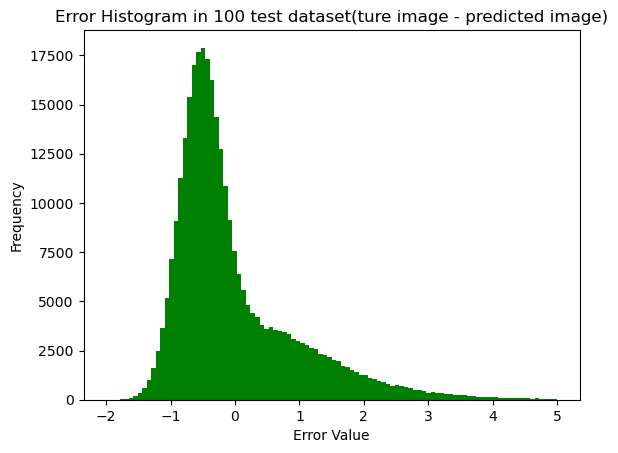

In [6]:
import matplotlib.pyplot as plt
num_cases_to_plot = 100
test_samples = list(test_loader)[:num_cases_to_plot]  # Take the first few batches (each batch might have more than one sample)
#Set the model to evaluation mode
model.eval()

# Initialize lists to hold predictions and true values
predicted_images = []
true_images = []
error_images = []
# Make predictions
with torch.no_grad():
    for X_test, Y_test in test_samples:
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        outputs = model(X_test)
        predicted_images.append(outputs.cpu().numpy())
        true_images.append(Y_test.cpu().numpy())
        
predicted_images = np.concatenate(predicted_images, axis=0)
predicted_images = [item for sublist in predicted_images for item in sublist]
true_images = np.concatenate(true_images, axis=0)
true_images = [item for sublist in true_images for item in sublist]

# Calculate errors
error_images = [true_images[i] - predicted_images[i] for i in range(len(true_images))]
hist, bin_edges = np.histogram(error_images, bins=100, range=(-2, 5))
# 找到频率最高的 bin 的索引
max_bin_index = np.argmax(hist)
# 计算该 bin 的范围
max_bin_range = (bin_edges[max_bin_index], bin_edges[max_bin_index + 1])
bias = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
print(f"频率最高的 bin 的范围是: {max_bin_range}")
# Plotting the results
plt.hist(error_images, bins=100, range=(-2, 5), histtype='stepfilled', align='mid', orientation='vertical', color='green')
plt.title('Error Histogram in 100 test dataset(ture image - predicted image)')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.savefig('error_histogram.jpg')

In [12]:
import matplotlib.pyplot as plt

# Select a few test cases
num_cases_to_plot = 5
test_samples = list(test_loader)[:num_cases_to_plot]  # Take the first few batches (each batch might have more than one sample)
print(type(test_samples))
print(len(test_samples))
print(len(test_samples[0]))
print(test_samples[0][0].shape, test_samples[0][1].shape)
print(test_samples[0][0], test_samples[0][1])
# Set the model to evaluation mode
# model.eval()

# # Initialize lists to hold predictions and true values
# predicted_images = []
# true_images = []

# # Make predictions
# with torch.no_grad():
#     for X_test, Y_test in test_samples:
#         X_test, Y_test = X_test.to(device), Y_test.to(device)
#         outputs = model(X_test)
#         predicted_images.append(outputs.cpu().numpy())
#         print(type(predicted_images))
#         true_images.append(Y_test.cpu().numpy())

# # Flatten the lists
# predicted_images = np.concatenate(predicted_images, axis=0) + bias
# true_images = np.concatenate(true_images, axis=0)

# #All taken as exponential and minus one
# # predicted_images = np.exp(predicted_images) - 1
# # true_images = np.exp(true_images) - 1

# # Plotting the results
# fig, axes = plt.subplots(num_cases_to_plot, 2, figsize=(10, 4 * num_cases_to_plot))
# for i in range(num_cases_to_plot):
#     # Reshape the predictions and true values to the original image dimensions
#     pred_img = predicted_images[i].reshape(HEIGHT, WIDTH)
#     true_img = true_images[i].reshape(HEIGHT, WIDTH)

#     # Plot the true image
#     axes[i, 0].imshow(true_img, cmap='gray')
#     axes[i, 0].set_title(f'True Image {i+1}')
#     axes[i, 0].axis('off')

#     # Plot the predicted image
#     axes[i, 1].imshow(pred_img, cmap='gray')
#     axes[i, 1].set_title(f'Predicted Image {i+1}')
#     axes[i, 1].axis('off')

# plt.tight_layout()
# plt.savefig('result.jpg')


<class 'list'>
1
2
torch.Size([100, 9408]) torch.Size([100, 3136])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.5580],
        [0.0000, 0.1889, 0.0000,  ..., 0.0000, 0.0000, 1.3473],
        ...,
        [0.1575, 0.1330, 0.0000,  ..., 0.0000, 0.9422, 0.0000],
        [0.0000, 0.0000, 0.0744,  ..., 0.0000, 1.4588, 0.0000],
        [0.2028, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.5143]]) tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.3229],
        [0.0000, 0.0000, 0.0000,  ..., 1.9120, 0.0000, 4.3491],
        [0.0000, 1.8253, 0.0000,  ..., 2.6597, 0.2286, 1.4487],
        ...,
        [1.5856, 1.4405, 0.0000,  ..., 0.3380, 0.9331, 0.0000],
        [0.1434, 0.0000, 0.7956,  ..., 0.0000, 2.4349, 0.8022],
        [2.0960, 0.0000, 0.0000,  ..., 0.1467, 3.3477, 3.6376]])


误差像素图

In [ ]:
import matplotlib.colors as mcolors
Error_pixel_map = true_img - pred_img

cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['red', 'white', 'black'])
norm = mcolors.TwoSlopeNorm(vmin=Error_pixel_map.min(), vcenter=0, vmax=Error_pixel_map.max())

# 绘制误差像素图
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Error_pixel_map, cmap=cmap, norm=norm)
plt.colorbar(label='Error Value')
plt.title('Error Pixel Map')

# # 绘制颜色和数字的对应关系
# plt.subplot(1, 2, 2)
# gradient = np.linspace(-1, 1, 256).reshape(1, -1)
# gradient = np.vstack((gradient, gradient))
# plt.imshow(gradient, aspect='auto', cmap=cmap, norm=norm)
# plt.gca().yaxis.set_visible(False)
# plt.colorbar(label='Error Value')
# plt.title('Color and Value Mapping')

plt.tight_layout()
plt.show()
# plt.savefig('error_map.jpg')